#### Import bibliotek

In [0]:
from torchvision import transforms
from torchvision import datasets
import torch
import torch.nn.functional as F
from torch import nn
from datetime import datetime

#### Zmienne globalne uczenia

In [0]:
BATCH_SIZE = 16                                # wielkosc mini-batcha
EPOCHS = 150                                   # ilosc epok
CLASSES = 10                                   # ilosc klas zmiennej zaleznej 
IMG_HEIGHT = 32                                # wyokosc obrazka w pikselach
IMG_WIDTH = 32                                 # szerokos obrazka w pikselach
DIM = 3                                        # wymiar obrazka
TOTAL_SIZE = DIM * IMG_HEIGHT * IMG_WIDTH      # calkowity rozmiar obrazka
DEVICE = torch.device("cpu")                   # okreslenie miejsca obliczen w tym wypadku cpu
LEARNING_RATE = 0.01

#### Zaczytanie danych do DataLoadera

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

svhn_data_train=datasets.SVHN("svhn", split='train', transform=transform, target_transform=None, download=True)
svhn_data_test=datasets.SVHN("svhn", split='test', transform=transform, target_transform=None, download=True)

data_loader_train = torch.utils.data.DataLoader(svhn_data_train, batch_size = BATCH_SIZE, shuffle = True)
data_loader_test = torch.utils.data.DataLoader(svhn_data_test, batch_size = BATCH_SIZE, shuffle = False)

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


#### Eksploracja danych

In [5]:
s = set()
i = 0                                      # Ostatni batch moze byc niepelny
for images, labels in data_loader_train:
    for label in labels:
        s.add(label.tolist())
        i += 1
print('Train size:', i)

i = 0
for images, labels in data_loader_test:
    for label in labels:
        s.add(label.tolist())
        i += 1
print('Test size:', i)
print('Labels:', s)
print('Number of classes:', len(s))

Train size: 73257
Test size: 26032
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of classes: 10


#### Projekt sieci

In [0]:
class Net(nn.Module):
    
    def __init__(self,  n_classes = CLASSES):           # okreslenie ilosc klas na wyjsciu sieci
        super().__init__()
        self.layer1 = nn.Linear(TOTAL_SIZE, 1000)       # wejsciowo TOTAL_SIZE
        self.layer2 = nn.Linear(1000, 200)
        self.layer3 = nn.Linear(200, 50)
        self.layer4 = nn.Linear(50, n_classes)          # wyjsciowo n_classes = CLASSES
        
    def forward(self, x):
        x = x.view(-1, TOTAL_SIZE)                      # zmiana rozmiaru danych
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)                              # ostatnia warstwa bez funkcji aktywacji bo jest zaimlementowana
        return x                                        # w CrossEntropyLoss()

#### Trenowanie sieci i zwrocenie wynikow do wizualizacji

In [0]:
def train(net):
    

    optim = torch.optim.SGD(net.parameters(), lr = LEARNING_RATE)                 # okreslenie optymalizatora
    loss = nn.CrossEntropyLoss()                                                  # okreslenie funkcji straty
    
    print("Training...")
    current_time = datetime.now().strftime("%H:%M:%S")
    print("Start Time =", current_time)
    
    res_acc_train = []
    res_acc_test = []
    res_los_train = []
    res_los_train_batch = []
    
    for epoch in range(EPOCHS):
        
        net.train()
        
        total_loss_train = 0.0
        total_train = 0.0
        correct_train = 0.0
        total_test = 0.0
        correct_test = 0.0
        
        # treining sieci na zbiorze treningowym
        for images, labels in data_loader_train:
            
            images, labels = images.to(DEVICE), labels.to(DEVICE)                 # przeniesienie danych do DEVICE
            net.zero_grad()                                                       # wyczyszczenie gradientu
            pred = net.forward(images.view(-1, TOTAL_SIZE))                       # predykcja
            loss_ = loss(pred, labels)                                            # obliczenie funkcji straty dla batcha
            total_loss_train += loss_                                                   
            total_train += labels.size(0) 
            correct_train += (torch.max(pred.data, 1).indices == labels).sum().item()   # obliczenie poprawnie zakwalifikoawych obrazkow w batch
            loss_.backward()
            optim.step()
            
            # zapisanie rezultatow w kazdym batchu
            res_los_train_batch.append(loss_.tolist())
        
        # po kazdej epoce obliczenie bledu na zbiorze testowym      
        for images, labels in data_loader_test:
            
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            pred = net.forward(images.view(-1, TOTAL_SIZE))
            total_test += labels.size(0)
            correct_test += (torch.max(pred, 1).indices == labels).sum().item()
        
        # wyswietlenie wynikow po kazdej epoce
        print(f"Epoch {epoch}| loss train {total_loss_train:.5f}| accuracy train {correct_train / total_train * 100:.5f}| accuracy test {correct_test / total_test * 100:5f}")
        
        # zapisanie rezultatow po epoce
        res_acc_train.append(correct_train / total_train * 100)
        res_acc_test.append(correct_test / total_test * 100)
        res_los_train.append(total_loss_train)

    current_time = datetime.now().strftime("%H:%M:%S")
    print("End Time =", current_time)
        
    # Zwrocenie rezultatow posrednich obliczen
    return (res_acc_train, res_acc_test, res_los_train, res_los_train_batch)
        

In [8]:
net = Net().to(DEVICE)
res = train(net)

Training...
Start Time = 12:09:47
Epoch 0| loss train 10219.95215| accuracy train 18.86100| accuracy test 20.943454
Epoch 1| loss train 8909.21875| accuracy train 30.21827| accuracy test 42.897203
Epoch 2| loss train 6862.60498| accuracy train 49.09565| accuracy test 53.595575
Epoch 3| loss train 5620.90283| accuracy train 60.43109| accuracy test 57.586816
Epoch 4| loss train 4925.93164| accuracy train 65.87766| accuracy test 60.748310
Epoch 5| loss train 4473.26660| accuracy train 69.32034| accuracy test 67.904886
...
Epoch 144| loss train 382.29828| accuracy train 97.22347| accuracy test 82.751998
Epoch 145| loss train 393.25131| accuracy train 97.12109| accuracy test 81.161647
Epoch 146| loss train 444.19504| accuracy train 96.68564| accuracy test 81.757068
Epoch 147| loss train 457.58957| accuracy train 96.57644| accuracy test 81.499693
Epoch 148| loss train 463.86038| accuracy train 96.65697| accuracy test 82.486939
Epoch 149| loss train 370.62714| accuracy train 97.32585| accurac

#### Wizualizacja rezultatow

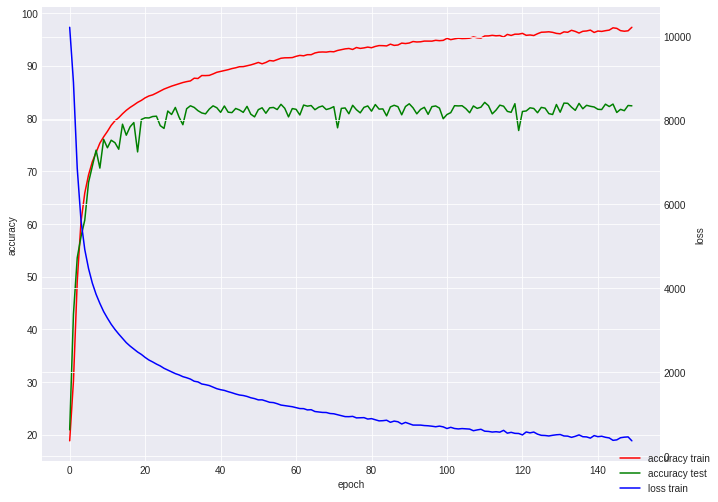

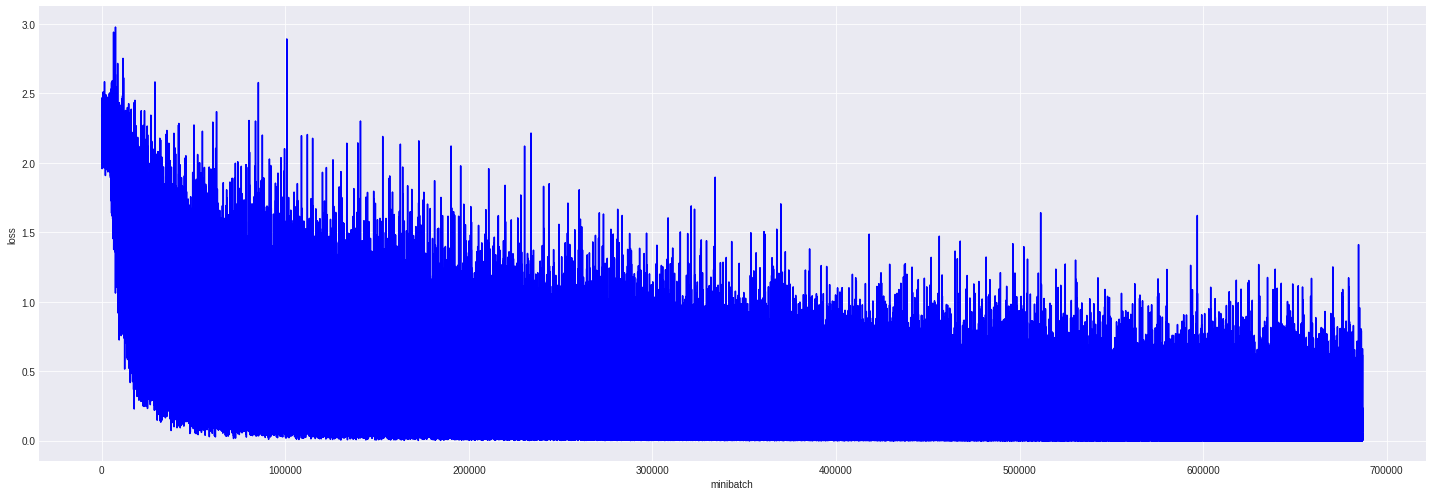

In [14]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')

def plot_results_epoch(res):

  fig, ax1 = plt.subplots(figsize = [10, 7])

  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.plot([i for i in range(len(res[0]))], res[0], color = 'r', label = 'accuracy train')
  ax1.plot([i for i in range(len(res[1]))], res[1], color = 'g', label = 'accuracy test')

  ax2 = ax1.twinx()  

  ax2.set_ylabel('loss')
  ax2.plot([i for i in range(len(res[2]))], res[2], color = 'blue', label = 'loss train')
  fig.legend(loc = 'lower right')
  fig.tight_layout()  
  
  plt.show()

  fig, ax = plt.subplots(figsize = [20, 7])

  ax.set_xlabel('minibatch')
  ax.set_ylabel('loss')
  ax.plot([i for i in range(len(res[3]))], res[3], color = 'blue')

  fig.tight_layout()  
  plt.show()


plot_results_epoch(res)